In [26]:

import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sbn

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.svm import SVC

import argparse
from datetime import datetime

import sys 
import uuid
import os

/home/teddy/miniconda3/envs/lc_reporter/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [38]:
class O: 
    def __init__(self): 
        O.load = ['raw']
        O.data = ['/home/teddy/local/live_cell_reporter_imaging/data/HER2_EFM192A_data_11-1-21/HER2_EFM192A_data_11-1-21/']
        O.drug = ['neratinib']
        O.resample_sz = [75]
        O.nclus = [5]
        O.sensitive_line = ['WT']
        O.resistant_line = ['T798I']
args = O()


In [47]:

print('\nsloading data...')
load = args.load[0].lower()
data_dir = args.data[0]
datasets = [x for x in os.listdir(data_dir) if os.path.isdir(data_dir + x)]

print('# of datasets to load:',len(datasets))

series_sel = pd.read_csv(data_dir + datasets[0] + '/' + load + '/clover_all_cell.csv').columns[1:-3]

_datas = []
for dataset in datasets: 
    cl_path = data_dir + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = data_dir + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)

data = pd.concat(_datas, axis=0)

clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_')[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()


sloading data...
# of datasets to load: 14


track_index       0_x      15_x      30_x  \
0  95_1000820656_efm192a_erk_akt__wt_untreated  0.614204  0.613644  0.604215   
1  95_1000824156_efm192a_erk_akt__wt_untreated  0.796560  0.675594  0.681481   
2  95_1000820506_efm192a_erk_akt__wt_untreated  0.929764  0.830124  0.762827   
3   4_1000034926_efm192a_erk_akt__wt_untreated  0.648266  0.584383  0.518272   
4  98_1000855728_efm192a_erk_akt__wt_untreated  0.705933  0.661050  0.637281   

       45_x      60_x      75_x      90_x     105_x     120_x  ...    2190_y  \
0  0.618300  0.619398  0.657024  0.713075  0.695760  0.726159  ...  0.079882   
1  0.660498  0.661479  0.717524  0.756510  0.765050  0.765040  ...  0.250697   
2  0.776301  0.758100  0.758652  0.761263  0.710535  0.697256  ...  0.562772   
3  0.520088  0.488933  0.540514  0.603546  0.628614  0.599961  ...  0.653183   
4  0.571563  0.542889  0.514811  0.501832  0.494177  0.502280  ...  0.768634   

     2205_y    2220_y    2235_y  site_y  median_y       dataset       drug  \
0  0.067956  0.075988  0.082853      95  0.294573  H210514_Set1  untreated   
1  0.243494  0.245351  0.243322      95  0.348082  H210514_Set1  untreated   
2  0.489134  0.552784  0.620420      95  0.623733  H210514_Set1  untreated   
3  0.622701  0.613495  0.611405       4  0.608579  H210514_Set1  untreated   
4  0.773763  0.790160  0.818764      98  0.673437  H210514_Set1  untreated   

   cell_line  mutant  
0    efm192a      wt  
1    efm192a      wt  
2    efm192a      wt  
3    efm192a      wt  
4    efm192a      wt  

[5 rows x 310 columns]

In [49]:
[x for x in data.track_index.values if 'T759del' in x]

['20_1000088444_efm192a_erk_akt__L755_T759del_untreated',
 '76_1000316726_efm192a_erk_akt__L755_T759del_untreated',
 '76_1000315853_efm192a_erk_akt__L755_T759del_untreated',
 '79_1000333953_efm192a_erk_akt__L755_T759del_untreated',
 '78_1000330209_efm192a_erk_akt__L755_T759del_untreated',
 '78_1000328397_efm192a_erk_akt__L755_T759del_untreated',
 '22_1000099405_efm192a_erk_akt__L755_T759del_untreated',
 '75_1000311231_efm192a_erk_akt__L755_T759del_untreated',
 '75_1000310322_efm192a_erk_akt__L755_T759del_untreated',
 '76_1000316494_efm192a_erk_akt__L755_T759del_untreated',
 '22_1000097884_efm192a_erk_akt__L755_T759del_untreated',
 '75_1000311376_efm192a_erk_akt__L755_T759del_untreated',
 '79_1000335473_efm192a_erk_akt__L755_T759del_untreated',
 '78_1000329623_efm192a_erk_akt__L755_T759del_untreated',
 '76_1000315145_efm192a_erk_akt__L755_T759del_untreated',
 '77_1000323902_efm192a_erk_akt__L755_T759del_untreated',
 '78_1000326728_efm192a_erk_akt__L755_T759del_untreated',
 '76_100031709

In [52]:
data[lambda x: x.drug == 'trastuzumab']

track_index       0_x      15_x  \
622      204_1001989685_efm192a_erk_akt__wt_trastuzumab  0.919513  0.791309   
623      204_1001986786_efm192a_erk_akt__wt_trastuzumab  1.318358  1.104472   
624      297_1002871213_efm192a_erk_akt__wt_trastuzumab  0.565254  0.525296   
625      297_1002865781_efm192a_erk_akt__wt_trastuzumab  0.628287  0.550122   
626      299_1002884760_efm192a_erk_akt__wt_trastuzumab  0.720239  0.682602   
...                                                 ...       ...       ...   
2521   194_1000684741_efm192a_erk_akt__S963_trastuzumab  0.291862  0.264043   
2522   194_1000683006_efm192a_erk_akt__S963_trastuzumab  0.581513  0.582768   
2523   195_1000689146_efm192a_erk_akt__S963_trastuzumab  0.564247  0.531939   
2524   207_1000706772_efm192a_erk_akt__S963_trastuzumab  0.392200  0.326384   
2531  202_1000690883_efm192a_erk_akt__N488S_trastuzumab  0.232169  0.211851   

          30_x      45_x      60_x      75_x      90_x     105_x     120_x  \
622   0.643348  0.636877  0.610035  0.643806  0.653662  0.636423  0.643299   
623   1.041894  0.992047  0.939191  1.091045  1.618872  1.642560  1.679468   
624   0.514245  0.483715  0.576773  0.575702  0.554462  0.566891  0.579022   
625   0.509990  0.568764  0.591910  0.596096  0.580491  0.583744  0.601825   
626   0.666135  0.604362  0.696516  0.756407  0.799762  0.864445  0.857488   
...        ...       ...       ...       ...       ...       ...       ...   
2521  0.251329  0.251154  0.237630  0.230955  0.221852  0.217818  0.195709   
2522  0.566893  0.563722  0.547340  0.528194  0.531447  0.502214  0.501203   
2523  0.534312  0.523053  0.531012  0.543135  0.543562  0.556411  0.485228   
2524  0.357390  0.392114  0.400074  0.417919  0.396069  0.376841  0.388821   
2531  0.420649  0.341193  0.302369  0.344599  0.326505  0.314045  0.309726   

      ...    2190_y    2205_y    2220_y    2235_y  site_y  median_y  \
622   ...  0.669723  0.647661  0.636646  0.635588     204  0.670449   
623   ...  0.416403  0.425001  0.414682  0.415011     204  0.460063   
624   ...  0.537469  0.532544  0.518409  0.527261     297  0.569637   
625   ...  0.178359  0.178359  0.178359  0.178359     297  0.415708   
626   ...  0.216917  0.217519  0.384871  0.218468     299  0.635050   
...   ...       ...       ...       ...       ...     ...       ...   
2521  ...  0.587376  0.595860  0.610469  0.610066     194  0.560106   
2522  ...  0.370491  0.373906  0.390356  0.388412     194  0.381906   
2523  ...  0.280379  0.295018  0.295018  0.295018     195  0.401332   
2524  ...  0.108965  0.529907  0.574234  0.111233     207  0.578633   
2531  ...  0.145218  0.162247  0.095895  0.251309     202  0.406169   

              dataset         drug  cell_line  mutant  
622      H210514_Set1  trastuzumab    efm192a      wt  
623      H210514_Set1  trastuzumab    efm192a      wt  
624      H210514_Set1  trastuzumab    efm192a      wt  
625      H210514_Set1  trastuzumab    efm192a      wt  
626      H210514_Set1  trastuzumab    efm192a      wt  
...               ...          ...        ...     ...  
2521  H210917_EFM192A  trastuzumab    efm192a    S963  
2522  H210917_EFM192A  trastuzumab    efm192a    S963  
2523  H210917_EFM192A  trastuzumab    efm192a    S963  
2524  H210917_EFM192A  trastuzumab    efm192a    S963  
2531  H210917_EFM192A  trastuzumab    efm192a   N488S  

[20671 rows x 310 columns]

In [48]:
data.drug.unique()

array(['untreated', 'neratinib', 'trastuzumab', 'T759del_untreated',
       'T759del_neratinib', 'T759del_trastuzumab'], dtype=object)

In [46]:
########### FILTER TO DRUG & REMOVE NA ##############
print('\nfiltering to drug and removing NAs...')

# new 
assert data.drug.unique().shape[0] == 3, f'expected three unique treatments before drug filter, got: {data.drug.unique()}'

if args.drug[0].lower() == 'neratinib': 
    drug_ = '10nm_neratinib'
else: 
    drug_ = '10ug_ml_trastuzumab'

data = data[lambda x: x.drug.isin(['untreated', drug_])]
print('Data shape (untreated + drug):', data.shape)

# new <---- 
assert data.drug.unique().shape[0] == 2, f'expected two unique treatments, got: {data.drug.unique()}'

print('length of time series BEFORE removing time points with NA', len(clover_sel))
clover_sel = np.array(clover_sel)[~data[clover_sel].isna().any()]
mscarl_sel = np.array(mscarl_sel)[~data[mscarl_sel].isna().any()]
assert len(clover_sel) == len(mscarl_sel), 'clover timeseries is different length than mscarlet time series'
print('length of time series AFTER removing time points with NA', len(clover_sel))




filtering to drug and removing NAs...
Data shape (untreated + drug): (20827, 310)


AssertionError: expected two unique treatments, got: ['untreated']

In [31]:
########### RESAMPLE ##############
print('\nresampling time series...')

X_train = np.stack([data[clover_sel], data[mscarl_sel]], axis=2)
print('Training data shape BEFORE resampling:', X_train.shape)

# Make time series shorter
X_train = TimeSeriesResampler(sz=args.resample_sz[0]).fit_transform(X_train)
print('Training data shape AFTER resampling:', X_train.shape)


resampling time series...
Training data shape BEFORE resampling: (20827, 150, 2)
Training data shape AFTER resampling: (20827, 75, 2)



performing time-series kmeans clustering...

4.041 --> 2.932 --> 2.791 --> 2.734 --> 2.713 --> 2.692 --> 2.662 --> 2.631 --> 2.608 --> 2.594 --> 2.586 --> 2.581 --> 2.579 --> 2.577 --> 2.576 --> 2.575 --> 2.574 --> 2.574 --> 2.574 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 2.573 --> 



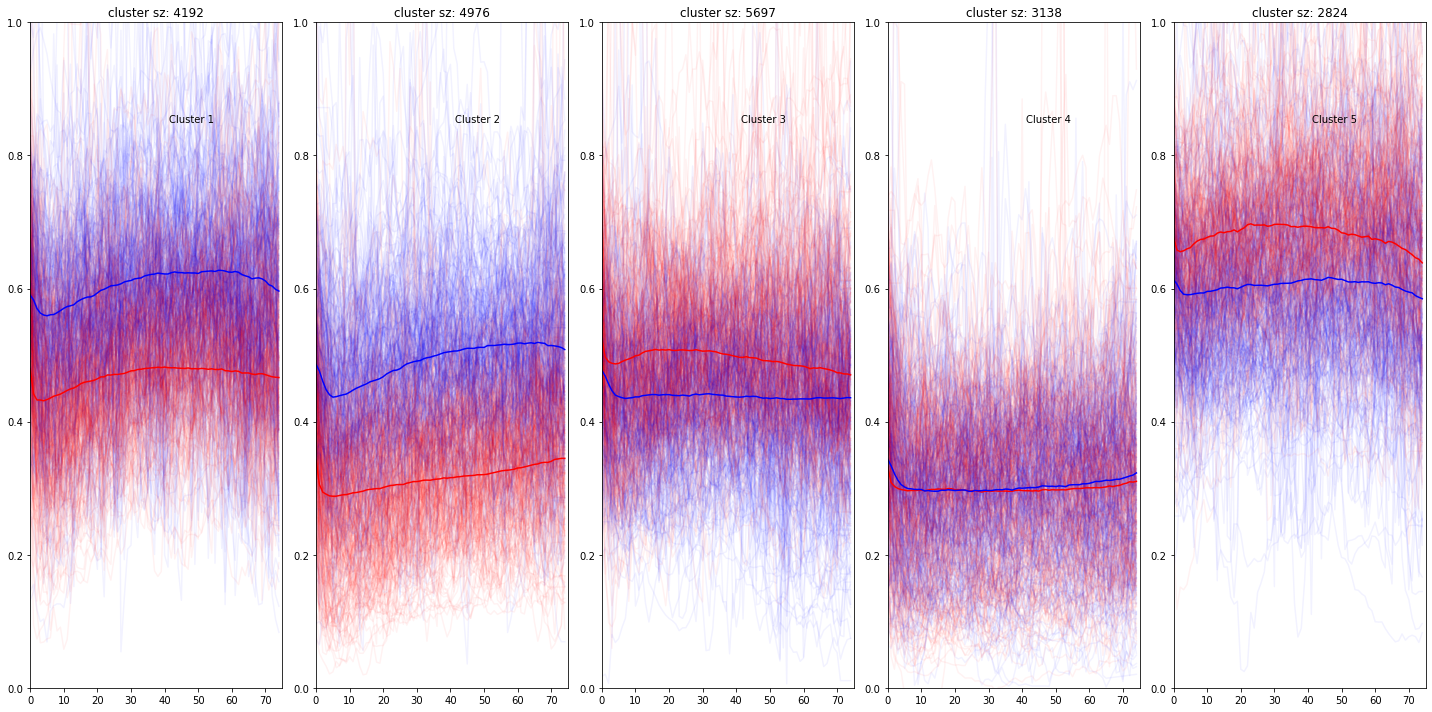

In [34]:

########### FIT K-MEANS ##############
print('\nperforming time-series kmeans clustering...')
print()
#                                                      random_state=0, 
km = TimeSeriesKMeans(n_clusters=args.nclus[0], verbose=True,metric='euclidean', n_jobs=8)
y_pred = km.fit_predict(X_train)
print()

F = plt.figure(figsize=(20,10))
for yi in range(args.nclus[0]):
    if args.nclus[0] % 5 == 0: 
        nrows = int(args.nclus[0] / 5) 
    else: 
        nrows = int(args.nclus[0] / 5)  + 1

    plt.subplot(nrows, 5, yi + 1)
    for xx in X_train[y_pred == yi][0:250]:
        plt.plot(xx[:,0], "r-", alpha=.05)
        plt.plot(xx[:,1], "b-", alpha=.05)

    plt.title(f'cluster sz: {len(X_train[y_pred == yi])}')
    plt.plot(km.cluster_centers_[yi][:,0], "r-", label='clover')
    plt.plot(km.cluster_centers_[yi][:,1], "b-", label='mscarlet')

    plt.xlim(0, args.resample_sz[0])
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()
plt.close('all')


In [35]:
########### CALCULATE CLUST PROPORTIONS ##############
print('\nquantifying experiment by cluster proportions...')
lb = LabelEncoder()
y_trt = lb.fit_transform([f'{x}--{y}' for x,y in zip(data.cell__treatment.values, data.dataset.values)])

cm_cnts = {c:np.zeros(args.nclus[0]) for c in lb.classes_} 

for i, clus, grp in zip(range(len(y_pred)), y_pred, y_trt) :
    cm_cnts[lb.classes_[grp]][clus] += 1

cm_prob = {k:v/np.sum(v) for k,v in cm_cnts.items()}

labels = [k for k,v in cm_prob.items()]
cm = np.stack([v for k,v in cm_prob.items()], axis=0)
        



quantifying experiment by cluster proportions...


<Figure size 504x504 with 0 Axes>

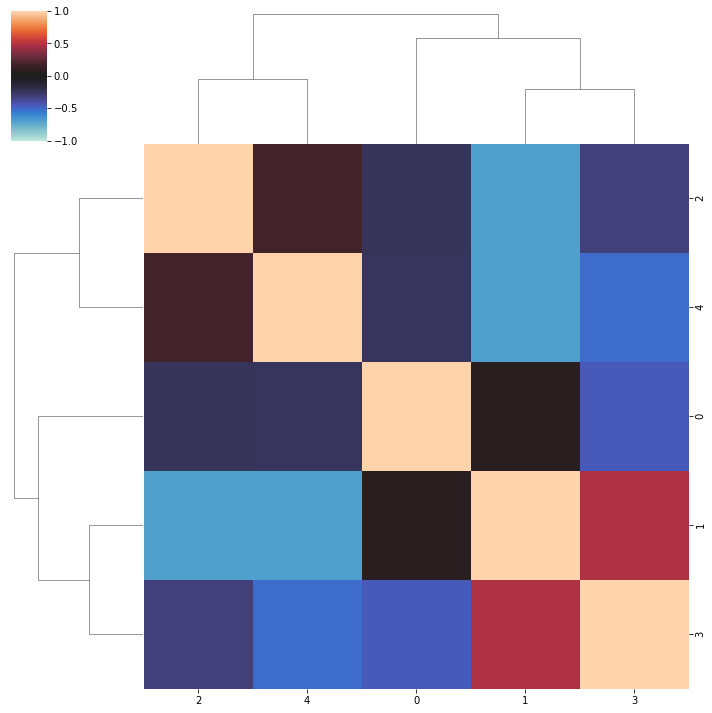

In [36]:
########### PLOT CLUSTER CORR ##############

corr = np.corrcoef(cm, rowvar=False)

f = plt.figure(figsize=(7,7))
ax = sbn.clustermap(
    corr, 
    vmin=-1, vmax=1, center=0,
)
plt.show()
plt.close('all')

In [41]:
lb.classes_

array(['efm192a__A1160V_untreated--H210820',
       'efm192a__A355Qfs76_untreated--H210827_Set1',
       'efm192a__A37T_untreated--H210827_Set2',
       'efm192a__D639E_untreated--H210827_Set1',
       'efm192a__G778P780dup_untreated--H210820',
       'efm192a__I767M_untreated--H210827_Set2',
       'efm192a__L313V_untreated--H210827_Set2',
       'efm192a__L755T759del_untreated--H210827_Set1',
       'efm192a__L785F_untreated--H210820',
       'efm192a__L869R_untreated--H210820',
       'efm192a__R47C_untreated--H210827_Set2',
       'efm192a__R678Q_untreated--H210827_Set1',
       'efm192a__S310Y_untreated--H210827_Set2',
       'efm192a__T733I_untreated--H210827_Set1',
       'efm192a__V424I_untreated--H210827_Set1',
       'efm192a__V842I_untreated--H210827_Set1',
       'efm192a__Y64F_untreated--H210827_Set2',
       'efm192a__Y772V773insRDGE_untreated--H210827_Set2',
       'efm192a__nd611_untreated--H210820',
       'efm192a__nd611_untreated--H210827_Set1',
       'efm192a__nd61


performing dim. reduction (pca)...
PCA explained variance ratio: [0.57504387 0.20259233]
PC shape: (133, 2)


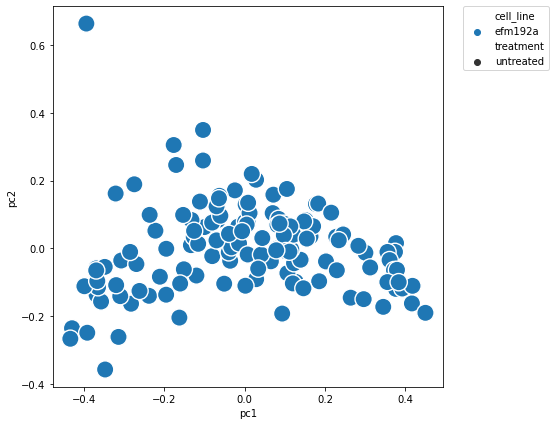

No handles with labels found to put in legend.


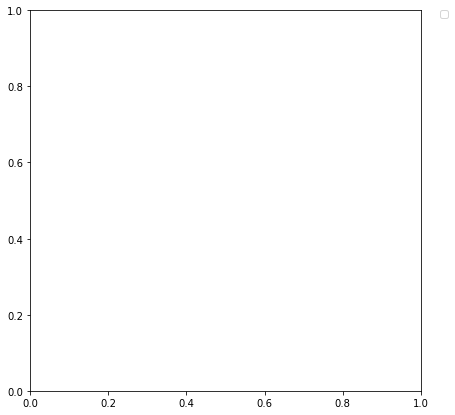

pc1       pc2  treatment cell_line
0  0.263873 -0.145745  untreated   efm192a
1  0.069642  0.103897  untreated   efm192a
2 -0.176814  0.304833  untreated   efm192a
3  0.163820  0.035080  untreated   efm192a
4 -0.162665 -0.204504  untreated   efm192a

In [45]:
########### DIM. REDUCTION ##############
_sens = args.sensitive_line[0].upper()
_res = args.resistant_line[0].upper()
_drug = args.drug[0].lower()

print('\nperforming dim. reduction (pca)...')
pca = PCA(n_components=2)
PCs = pca.fit_transform(cm)

print('PCA explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)


#old
#res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})

#new 
res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[0] for x in lb.classes_]})


plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res[lambda x: (x.cell_line.isin([_sens, _res]))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close('all')
        
res.head()

In [ ]:
  ########### TRAIN CLASSIFIER ##############
        print('\ntraining classifier...')
        
        print('sensitive line:', _sens)
        print('resistant line:', _res)
        print('drug:', _drug)
        
        res_drug = res[lambda x: (x.cell_line.isin([_sens, _res])) & (x.treatment == _drug)]
        print('drug + WT df size: ', res_drug.shape)

        X = res_drug[['pc1', 'pc2']].values
        y_res = ((res_drug.cell_line == _res).values)
        y_sens = ((res_drug.cell_line == _sens).values)

        assert (y_res == ~y_sens).all(), 'y class label assignment has more than 2 classes...'
        
        y = 1*y_sens
        
        print('X train shape:', X.shape)
        print('# neg class (resistant):', np.sum(y_res))
        print('# pos class (sensitive):', np.sum(y_sens))
         
        #                                                 , random_state=0
        model = SVC(kernel='linear', C=10, probability=True)
        model.fit(X,y) 
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        
        plt.figure(figsize=(10, 5))
        plt.subplots_adjust(bottom=.2, top=.95)
        
        #xx = np.linspace(-1, 1, 100)
        #yy = np.linspace(-1, 1, 100).T
        xx = np.linspace(min(X[:,0]), max(X[:,0]), 100)
        yy = np.linspace(min(X[:,1]), max(X[:,1]), 100).T
        xx, yy = np.meshgrid(xx, yy)
        Xfull = np.c_[xx.ravel(), yy.ravel()]
        
        # View probabilities:
        probas = model.predict_proba(Xfull)
        n_classes = np.unique(y_pred).size
        class_names = ['resistant', 'sensitive']
        name = 'Support Vector Classifier'
        for k in range(n_classes):
            plt.subplot(1, n_classes, 0 * n_classes + k + 1)
            plt.title("%s class" % class_names[k])
            if k == 0:
                plt.ylabel(name)
            imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                       extent=(-1, 1, -1, 1), origin='lower')
            plt.xticks(())
            plt.yticks(())
            idx = (y_pred == k)
            if idx.any():
                plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')
        
        ax = plt.axes([0.15, 0.04, 0.7, 0.05])
        plt.title("Probability")
        plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

        plt.savefig(output_dir + '/classifier_results.png',bbox_inches='tight')
        plt.close('all')
        
        ########### APPLY TO UNLABELED CELL LINES ##############
        print('\npredicting unlabeled sensitivities...')
        _other = res[lambda x: ~(x.cell_line.isin([args.sensitive_line[0].lower(), args.resistant_line[0].lower()])) & (x.treatment == args.drug[0].lower())].reset_index(drop=True)

        X_all = _other[['pc1', 'pc2']].values

        y_hat = model.predict_proba(X_all)

        pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1]})
        prob_res = pd.concat([_other, pres], axis=1) 
        prob_res = prob_res.assign(call=[['res','sens'][np.argmax([x,y])] for x,y in zip(prob_res.prob_res, prob_res.prob_sens)])
        
        ########### SAVE RESULTS ##############
        print('\nsaving results...')
        
        prob_res.to_csv(output_dir + '/unlabeled_lines_results.csv') 
        
        run_res = pd.DataFrame({'accuracy(train)': accuracy, 
                                'pc1_var':pca.explained_variance_ratio_[0], 
                                'pc2_var':pca.explained_variance_ratio_[1], 
                                'kmeans_inertia': km.inertia_,
                                'res_line':_res, 
                                'sens_line': _sens,
                                'drug':_drug, 
                                'nclus':args.nclus[0],
                                'resample_sz': args.resample_sz[0],
                                'load': args.load[0], 
                                'run_id':run_id}, index=[0])
        
        run_res.to_csv(output_dir + '/run_results.csv')
                         
                         

In [ ]:
  ########### TRAIN CLASSIFIER ##############
        print('\ntraining classifier...')
        
        print('sensitive line:', _sens)
        print('resistant line:', _res)
        print('drug:', _drug)
        
        res_drug = res[lambda x: (x.cell_line.isin([_sens, _res])) & (x.treatment == _drug)]
        print('drug + WT df size: ', res_drug.shape)

        X = res_drug[['pc1', 'pc2']].values
        y_res = ((res_drug.cell_line == _res).values)
        y_sens = ((res_drug.cell_line == _sens).values)

        assert (y_res == ~y_sens).all(), 'y class label assignment has more than 2 classes...'
        
        y = 1*y_sens
        
        print('X train shape:', X.shape)
        print('# neg class (resistant):', np.sum(y_res))
        print('# pos class (sensitive):', np.sum(y_sens))
         
        #                                                 , random_state=0
        model = SVC(kernel='linear', C=10, probability=True)
        model.fit(X,y) 
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        
        plt.figure(figsize=(10, 5))
        plt.subplots_adjust(bottom=.2, top=.95)
        
        #xx = np.linspace(-1, 1, 100)
        #yy = np.linspace(-1, 1, 100).T
        xx = np.linspace(min(X[:,0]), max(X[:,0]), 100)
        yy = np.linspace(min(X[:,1]), max(X[:,1]), 100).T
        xx, yy = np.meshgrid(xx, yy)
        Xfull = np.c_[xx.ravel(), yy.ravel()]
        
        # View probabilities:
        probas = model.predict_proba(Xfull)
        n_classes = np.unique(y_pred).size
        class_names = ['resistant', 'sensitive']
        name = 'Support Vector Classifier'
        for k in range(n_classes):
            plt.subplot(1, n_classes, 0 * n_classes + k + 1)
            plt.title("%s class" % class_names[k])
            if k == 0:
                plt.ylabel(name)
            imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                       extent=(-1, 1, -1, 1), origin='lower')
            plt.xticks(())
            plt.yticks(())
            idx = (y_pred == k)
            if idx.any():
                plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')
        
        ax = plt.axes([0.15, 0.04, 0.7, 0.05])
        plt.title("Probability")
        plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

        plt.savefig(output_dir + '/classifier_results.png',bbox_inches='tight')
        plt.close('all')
    

In [ ]:

        ########### APPLY TO UNLABELED CELL LINES ##############
        print('\npredicting unlabeled sensitivities...')
        _other = res[lambda x: ~(x.cell_line.isin([args.sensitive_line[0].lower(), args.resistant_line[0].lower()])) & (x.treatment == args.drug[0].lower())].reset_index(drop=True)

        X_all = _other[['pc1', 'pc2']].values

        y_hat = model.predict_proba(X_all)

        pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1]})
        prob_res = pd.concat([_other, pres], axis=1) 
        prob_res = prob_res.assign(call=[['res','sens'][np.argmax([x,y])] for x,y in zip(prob_res.prob_res, prob_res.prob_sens)])
        

                         

In [ ]:
        ########### SAVE RESULTS ##############
        print('\nsaving results...')
        
        prob_res.to_csv(output_dir + '/unlabeled_lines_results.csv') 
        
        run_res = pd.DataFrame({'accuracy(train)': accuracy, 
                                'pc1_var':pca.explained_variance_ratio_[0], 
                                'pc2_var':pca.explained_variance_ratio_[1], 
                                'kmeans_inertia': km.inertia_,
                                'res_line':_res, 
                                'sens_line': _sens,
                                'drug':_drug, 
                                'nclus':args.nclus[0],
                                'resample_sz': args.resample_sz[0],
                                'load': args.load[0], 
                                'run_id':run_id}, index=[0])
        
        run_res.to_csv(output_dir + '/run_results.csv')
                         

In [18]:
class O: 
    def __init__(self): 
        O.load = ['raw']
        O.data = ['/home/teddy/local/live_cell_reporter_imaging/data/HER2_SKBR3_data_6-7-21/HER2_SKBR3_data_6-7-21/']
args = O()

print('\nsloading data...')
load = args.load[0].lower()
data_dir = args.data[0]
datasets = [x for x in os.listdir(data_dir) if os.path.isdir(data_dir + x)]

print('# of datasets to load:',len(datasets))

series_sel = pd.read_csv(data_dir + datasets[0] + '/' + load + '/clover_all_cell.csv').columns[1:-3]

_datas = []
for dataset in datasets: 
    cl_path = data_dir + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = data_dir + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)

data = pd.concat(_datas, axis=0)

clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()


sloading data...
# of datasets to load: 13


track_index       0_x      15_x      30_x  \
0   3_1000011860_skbr3_erk_akt__WT_untreated  0.939628  0.891530  0.562608   
1  79_1000288819_skbr3_erk_akt__WT_untreated  0.716700  0.828169  0.846997   
2  78_1000285319_skbr3_erk_akt__WT_untreated  0.893122  0.918505  0.800166   
3   1_1000002701_skbr3_erk_akt__WT_untreated  0.925266  0.887206  0.927599   
4  78_1000282488_skbr3_erk_akt__WT_untreated  1.022995  0.889429  0.860142   

       45_x      60_x      75_x      90_x     105_x     120_x  ...  2805_y  \
0  0.834245  1.108023  0.760721  0.659259  0.557796  0.456334  ...     NaN   
1  0.810356  0.766408  0.789658  0.742649  0.811046  0.832033  ...     NaN   
2  0.872648  0.839871  0.880530  0.663143  0.968198  0.936171  ...     NaN   
3  0.950207  0.866647  0.869601  0.897597  0.888514  0.876737  ...     NaN   
4  0.693650  0.631249  0.591991  0.597955  0.685731  0.712077  ...     NaN   

   2820_y  2835_y  2850_y  2865_y  2880_y  2895_y       drug  cell_line  \
0     NaN     NaN     NaN     NaN     NaN     NaN  untreated      skbr3   
1     NaN     NaN     NaN     NaN     NaN     NaN  untreated      skbr3   
2     NaN     NaN     NaN     NaN     NaN     NaN  untreated      skbr3   
3     NaN     NaN     NaN     NaN     NaN     NaN  untreated      skbr3   
4     NaN     NaN     NaN     NaN     NaN     NaN  untreated      skbr3   

   mutant  
0      WT  
1      WT  
2      WT  
3      WT  
4      WT  

[5 rows x 398 columns]

In [19]:
data.columns

Index(['track_index', '0_x', '15_x', '30_x', '45_x', '60_x', '75_x', '90_x',
       '105_x', '120_x',
       ...
       '2805_y', '2820_y', '2835_y', '2850_y', '2865_y', '2880_y', '2895_y',
       'drug', 'cell_line', 'mutant'],
      dtype='object', length=398)